In [1]:
!git pull upstream master

From https://github.com/CSSEGISandData/COVID-19
 * branch            master     -> FETCH_HEAD
Already up-to-date.


In [30]:
%matplotlib inline
from datetime import datetime
from datetime import timedelta
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set(font_scale=1.5)

In [3]:
states = pd.read_excel('nst-est2019-01.xlsx', skiprows=3)
states.columns = ['Name' if i==0 else x for i, x in enumerate(states)]
states = states.rename(columns={2019: 'Population'})
states_pop = states.set_index('Name')[['Population']]
states_pop.index = states_pop.index.str.replace('.', '')
states_pop.head(10)

,Population
Name,
United States,328239523.0
Northeast,55982803.0
Midwest,68329004.0
South,125580448.0
West,78347268.0
Alabama,4903185.0
Alaska,731545.0
Arizona,7278717.0
Arkansas,3017804.0


In [4]:
country_pop = pd.read_csv('population-figures-by-country-csv_csv.csv').set_index('Country').iloc[:, -1:]
country_pop.columns = ['Population']
country_pop.head()

,Population
Country,
Aruba,104822.0
Afghanistan,34656032.0
Angola,28813463.0
Albania,2876101.0
Andorra,77281.0


In [23]:
confirmed = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
deaths = pd.read_csv('csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
dates = [col for col in confirmed if '20' in col] # Get columns that have the year in them, i.e. the dates

In [24]:
def get_state_counts(counts):
    counts_state = counts[counts['Country/Region']=='US'].set_index('Province/State').join(states_pop, how='inner')
    counts_state = counts_state[dates].div(counts_state['Population'], axis=0)
    return counts_state

confirmed_state = get_state_counts(confirmed)
deaths_state = get_state_counts(deaths)

In [25]:
def get_country_counts(counts):
    counts_country = counts[counts['Province/State'].isnull() | (counts['Province/State']==counts['Country/Region'])].set_index('Country/Region').join(country_pop, how='inner')
    counts_country = counts_country[dates].div(counts_country['Population'], axis=0)
    return counts_country

confirmed_country = get_country_counts(confirmed)
deaths_country = get_country_counts(deaths)

In [40]:
def make_merged(counts_state, counts_country, extrapolate=True):
    df = pd.concat([counts_state, counts_country])
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")  # Ignore log(0) error
        df = np.log10(df)
    df.columns = [datetime.strptime(x, '%m/%d/%y') for x in df.columns]
    if extrapolate:
        last = df.columns[-1]
        if df[last].isnull().mean() > 0.5:
            last = df.columns[-2]
        n_past = df.shape[1]
        for i in range(1, 101):
            df[last + timedelta(0, i*3600*24, 0)] = df[last]+(0.06*i)
            df._last = last
    else:
        df._last = None
    return df
        
df_confirmed = make_merged(confirmed_state, confirmed_country)
df_deaths = make_merged(deaths_state, deaths_country)

In [45]:
def make_plot(df, label, start='2/28/20', places=['Arizona', 'New York', 'California', 'Spain', 'France', 'Italy', 'Maine'], ylim=(-7,0)):
    first = datetime.strptime(start, '%m/%d/%y')
    colors = ['r', 'g', 'b', 'k', 'c', 'orange', 'gold', 'blue', 'brown', 'purple']
    ax = df.loc[places, :].loc[:, first:last].T.plot(figsize=(30, 10), linestyle='-', marker='o', color=colors[:len(places)])
    df.loc[places, :].loc[:, last:].T.plot(ax=ax, linestyle='--', legend=False, color=colors[:len(places)])
    tick_locs = df.columns[df.columns >= first]
    plt.xticks(tick_locs, [datetime.strftime(x, '%m/%d') for x in tick_locs], rotation=75);
    log_units = np.linspace(-6, 0, 7)
    plt.yticks(log_units, ['1 in %.0f' % (10.0**-x) for x in log_units]);
    plt.xlabel('Date')
    plt.ylabel('Number of residents per %s' % label);
    plt.ylim(-7, 0);

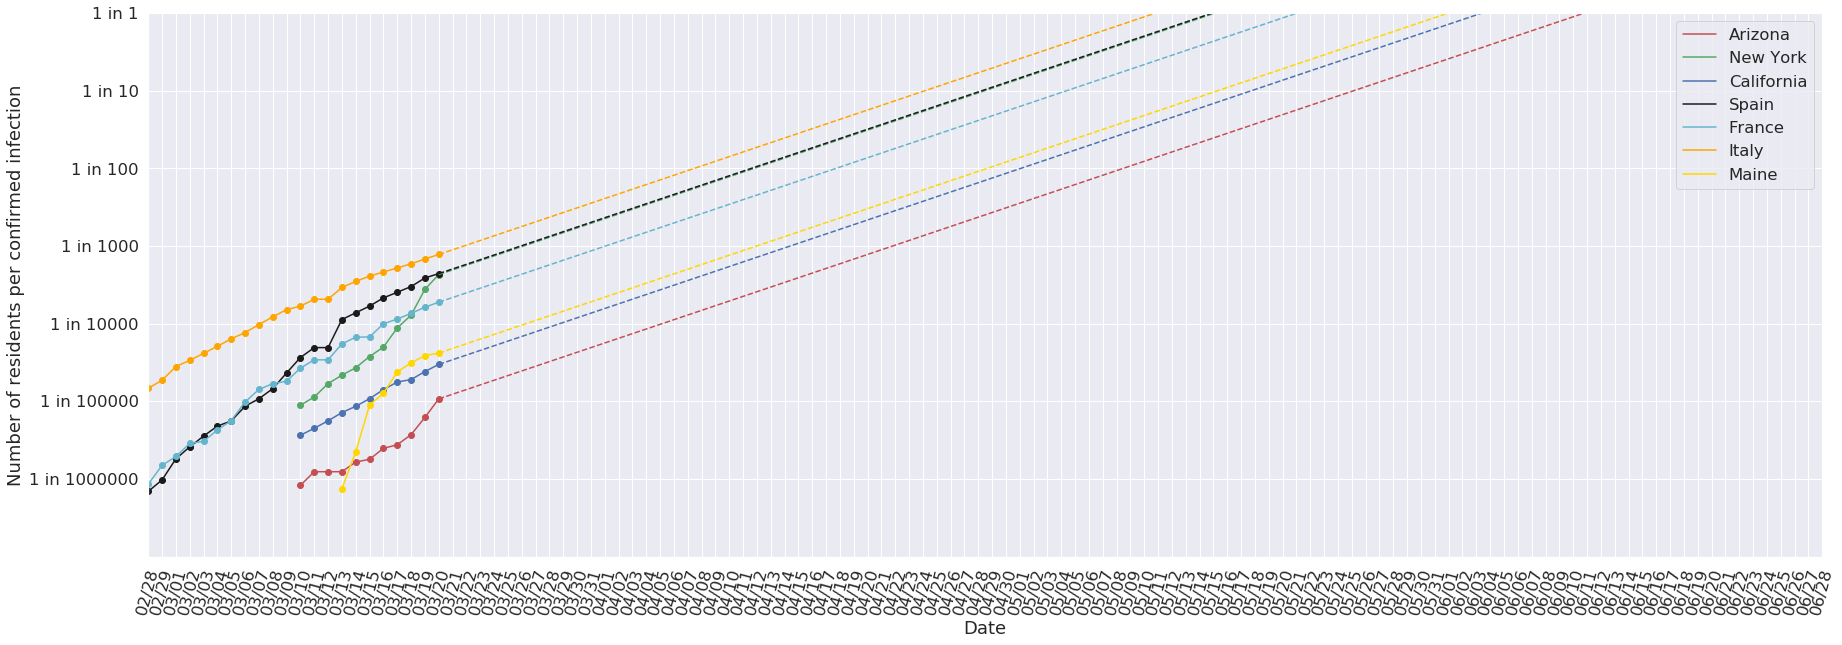

In [46]:
make_plot(df_confirmed, "confirmed infection")

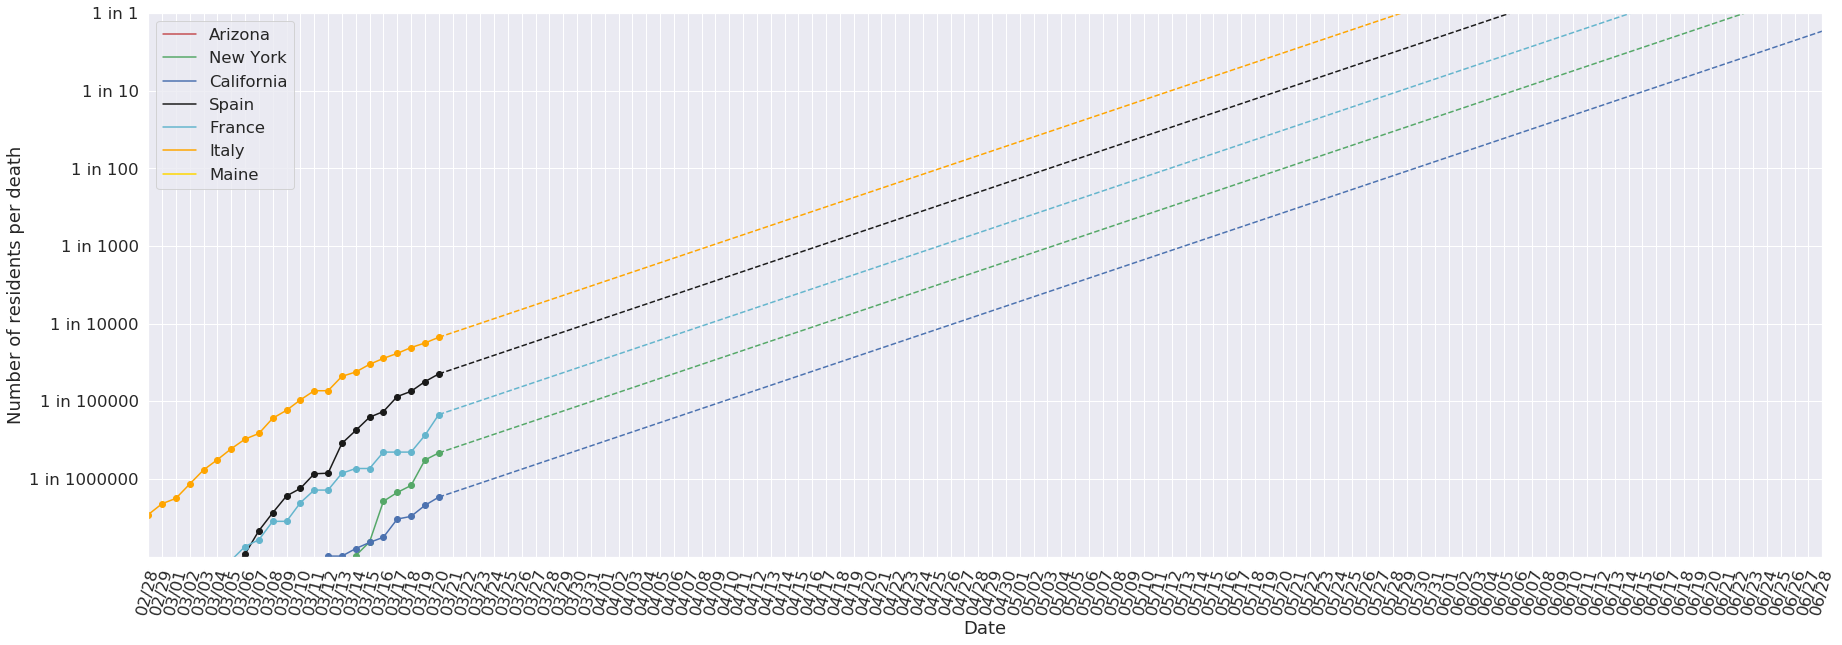

In [47]:
make_plot(df_deaths, "death", ylim=(-9,0))